# Library

In [1]:
# Install necessary packages
!pip install calmap duckdb sweetviz pygwalker xgboost pydot visualkeras graphviz lifelines pyarrow feather-format

In [2]:
# Basic libraries
import numpy as np
from numpy import inf
import pandas as pd
import warnings
from datetime import datetime

# Machine Learning libraries
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LogisticRegression, Lasso, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, f1_score, fbeta_score, mean_squared_error, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RepeatedStratifiedKFold, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler, OrdinalEncoder, PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier

# Imbalanced data handling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.offline as pyo
import calmap

# Other libraries
import requests
import tabulate
from scipy import stats
from scipy.stats import norm
import duckdb
import time
colors = ['#66b3ff', '#ff9999']

# Plotly offline mode
pyo.init_notebook_mode(connected=True)

# Set the warning filter to ignore
warnings.filterwarnings("ignore")

# Set the display options
pd.options.display.max_columns = None

# Set the color palette
sns.set_palette(sns.color_palette())

# Additional imports from the second snippet
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, RFE, SelectPercentile
from sklearn.compose import ColumnTransformer
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.plotting import add_at_risk_counts
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score, GridSearchCV
import matplotlib.patches as mpatches
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from scipy.stats import chi2
from sklearn.metrics import silhouette_score

%matplotlib inline


# Read file

In [3]:
# Read the Excel file and select specific sheets
sheets_to_read = ['Data']
df_dict = pd.read_excel("C:\\Users\\lekho\\OneDrive\\FIZO\\Loan Behavior\\Hello.xlsx", sheet_name=sheets_to_read)

# Access the data from each sheet using the sheet names as keys in the DataFrame dictionary
sheet1_data = df_dict['Data']

# Generating the dataframe
df = pd.DataFrame(sheet1_data)

In [4]:
# Shape of Fraud Detection data
print("Fraud Detection data -  rows:",df.shape[0]," columns:", df.shape[1])
df.info()

Fraud Detection data -  rows: 52135  columns: 63
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52135 entries, 0 to 52134
Data columns (total 63 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gmt_received_date          52135 non-null  object        
 1   gmt_received_week          52135 non-null  object        
 2   gmt_received_month         52135 non-null  object        
 3   product                    52135 non-null  object        
 4   gender                     37057 non-null  object        
 5   client_age                 37059 non-null  float64       
 6   id_type                    37059 non-null  object        
 7   customer_province_current  37051 non-null  object        
 8   job                        52135 non-null  object        
 9   marital_status             36905 non-null  object        
 10  region                     37051 non-null  object        
 11  telco_operator    

# Clean up

In [5]:
# Filtering the DataFrame
df = df[df['funnel'] != '2.GMT-Processing']

In [6]:
# Filtering the DataFrame
df = df[df['product'] == 'DICO MED_SMART YOUTH']

In [7]:
# Fill FPD30_OBS with 0 where approve is 1
mask = (df['flag_approve'] == 1) & (df['FPD30_OBS'].isna())
df.loc[mask, 'FPD30_OBS'] = 0
# Dropping unnecessary columnss
df = df.drop(['FPD1',	'FPD1_OBS',	'FPD5',	'FPD5_OBS',	'FPD10','FPD10_OBS', 'DEL30MOB4_BASE', 'DEL30MOB4_HIS', 'TPD30_OBS', 'TPD30', 'SPD30_OBS', 'SPD30','FST_PD30_OBS', 'FST_PD30', 'FS_PD30_OBS', 'FS_PD30','call_status'], axis=1)

In [8]:
# Fill %NA
data_df = df
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,FPD30,FPD30_OBS,GW_TELCO_SCORE,personMarriageStatus,personEduStatus,personPurposeOfLoan,telco_operator,first_call_date,personCurrentAddPro,marital_status,education,user,region,customer_province_current,id_type,loan_amount,client_age,gender,phone_number,productName,status,job,title,applicLoanTerm,security_phrase,city,state,product,gmt_received_month,called_count,personIDissuePlace,applicAmount,customerFullName,externalApplyNo,callTime,gmt_received_week,created_date,status_name,sub_funnel,total_app,flag_cancel,flag_reject,flag_approve,funnel,leadInfo,gmt_received_date
Total,5770.00000,5417.000000,3772.00000,1411.000000,706.000000,685.000000,660.000000,74.000000,14.000000,13.000000,10.000000,8.000000,6.000000,6.000000,3.000000,3.000000,3.000000,3.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,93.24499,87.540401,60.95669,22.802198,11.409179,11.069813,10.665805,1.195863,0.226244,0.210084,0.161603,0.129282,0.096962,0.096962,0.048481,0.048481,0.048481,0.048481,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Calculate the percentage of NA values in each column
na_cols = (df.isnull().sum() / df.shape[0]) * 100

# Select columns where the percentage of NA values is greater than 80%
cols_to_drop = na_cols[na_cols > 50].index

# # drop the selected columns from the DataFrame
# df = df.drop(columns=cols_to_drop)

In [10]:
filtered_df = df[df['FPD30_OBS'].notnull()]

In [11]:
# Clone X from df
X = filtered_df.copy()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(['object']).columns.tolist()

In [12]:
X.head(5)

,gmt_received_date,gmt_received_week,gmt_received_month,product,gender,client_age,id_type,customer_province_current,job,marital_status,region,telco_operator,education,loan_amount,leadInfo,funnel,flag_approve,flag_reject,flag_cancel,total_app,sub_funnel,status_name,created_date,first_call_date,callTime,externalApplyNo,customerFullName,personIDissuePlace,personCurrentAddPro,applicAmount,applicLoanTerm,personMarriageStatus,personEduStatus,personPurposeOfLoan,productName,user,status,phone_number,title,called_count,security_phrase,city,state,FPD30,FPD30_OBS,GW_TELCO_SCORE
427,2023-09-05,2023-09-04,2023-09,DICO MED_SMART YOUTH,Female,34.0,CCCD,Thành phố Hồ Chí Minh,OS-OTHER SERVICES,Divorced,SOUTHEAST,Viettel,High school,( 0-10],Data is missing,3.Full App Sent Dico,1,0,0,1,3.7. Dico disbursed,HS hoàn thành,2023-09-05 11:00:48,2023-09-05 11:27:56.0,Call < 30 mins,SLFZ693886309634,TRẦN NGỌC TRÂM ANH,Cục trưởng Cục Cảnh sát quản lý hành chính về ...,Hồ Chí Minh,10000000,12,NaN,NaN,NaN,dico med_smart youth,lamnguyen2,M1,968776987,SLFZ693886309634,2,10000000,12,dico med_smart youth,NaN,0.0,636.0
428,2023-09-04,2023-09-04,2023-09,DICO MED_SMART YOUTH,Female,29.0,CCCD,Thành phố Hồ Chí Minh,PU-PUBLIC SERVICE,Get married,SOUTHEAST,Viettel,High school,( 0-10],Data is missing,3.Full App Sent Dico,1,0,0,1,3.7. Dico disbursed,HS hoàn thành,2023-09-04 12:00:43,2023-09-05 08:32:52.0,Call > 60 mins,SLFZ693803229331,VÕ THỊ HỒNG Y,Cục trưởng Cục Cảnh sát quản lý hành chính về ...,Bình Định,10000000,12,NaN,NaN,NaN,dico med_smart youth,taicao1,M1,342291673,SLFZ693803229331,3,10000000,12,dico med_smart youth,NaN,0.0,567.0
443,2023-09-06,2023-09-04,2023-09,DICO MED_SMART YOUTH,Male,29.0,CCCD,Thành phố Hồ Chí Minh,CN-CONSTRUCTION,Single,SOUTHEAST,Mobiphone,University/College,(10-20],Data is missing,3.Full App Sent Dico,1,0,0,1,3.7. Dico disbursed,HS hoàn thành,2023-09-06 16:45:50,2023-09-07 09:11:05.0,Call > 60 mins,SLFZ693993062581,NGUYỄN KIM KHÁNH,Cục trưởng Cục Cảnh sát quản lý hành chính về ...,Phú Yên,20000000,12,NaN,NaN,NaN,dico med_smart youth,mynguyen1,M1,935124370,SLFZ693993062581,4,20000000,12,dico med_smart youth,NaN,0.0,773.0
450,2023-09-07,2023-09-04,2023-09,DICO MED_SMART YOUTH,Male,29.0,CCCD,Tỉnh Long An,TR-TRANSPORTING,Get married,MEKONG,Mobiphone,High school,(10-20],Data is missing,3.Full App Sent Dico,1,0,0,1,3.7. Dico disbursed,HS hoàn thành,2023-09-07 13:45:46,2023-09-07 14:36:47.0,Call < 60 mins,SLFZ694068408041,NGUYỄN THÀNH Y,Cục trưởng Cục Cảnh sát quản lý hành chính về ...,Long An,20000000,24,NaN,NaN,NaN,dico med_smart youth,xuanhuynh1,M1,901667889,SLFZ694068408041,5,20000000,24,dico med_smart youth,NaN,0.0,588.0
459,2023-09-08,2023-09-04,2023-09,DICO MED_SMART YOUTH,Female,33.0,CCCD,Tỉnh Bà Rịa - Vũng Tàu,WH-WHOLESALE,Get married,SOUTHEAST,Mobiphone,University/College,(10-20],Data is missing,3.Full App Sent Dico,1,0,0,1,3.7. Dico disbursed,HS hoàn thành,2023-09-08 16:30:48,2023-09-08 16:35:21.0,Call < 5 mins,SLFZ694164924609,NGUYỄN THỊ NGỌC BÍCH,Cục trưởng Cục Cảnh sát quản lý hành chính về ...,Bà Rịa Vũng Tàu,15000000,12,NaN,NaN,NaN,dico med_smart youth,duyennguyen1,M1,907868376,SLFZ694164924609,7,15000000,12,dico med_smart youth,NaN,0.0,692.0


In [13]:
# Define the columns for each cluster
customer_details_cols = ['gender', 'client_age', 'marital_status', 'personEduStatus']
loan_details_cols = ['applicAmount', 'applicLoanTerm','state']
areaandphone_cols = ['region', 'telco_operator']


# Define the number of clusters for each set of columns
customer_details_clusters = 4
loan_details_clusters = 4
areaandphone_clusters = 4

In [14]:
def cluster_columns(columns, X, n_clusters):
    # Filter the dataframe to include only the specified columns
    X_filtered = X[columns]

    # Get list of numeric and categorical features
    numeric_features = X_filtered.select_dtypes(include=np.number).columns.tolist()
    categorical_features = X_filtered.select_dtypes(include=['object', 'category']).columns.tolist()

    # Define the preprocessing pipeline for numeric columns
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    # Define the preprocessing pipeline for categorical columns
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Define the preprocessing column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ])

    # Perform TruncatedSVD on the preprocessed data, limiting to 2 components
    svd = TruncatedSVD(n_components=2)
    X_svd = svd.fit_transform(preprocessor.fit_transform(X_filtered))

    # Fit the KMeans model on the SVD-transformed data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X_svd)

    return cluster_labels

# Apply the clustering function to each list of columns with the predetermined number of clusters
customer_details_labels = cluster_columns(customer_details_cols, X, customer_details_clusters)
loan_details_labels = cluster_columns(loan_details_cols, X, loan_details_clusters)
areaandphone_labels = cluster_columns(areaandphone_cols, X, areaandphone_clusters)

# Add the cluster labels to the original dataframe
X['customer_details_cluster'] = customer_details_labels
X['loan_details_cluster'] = loan_details_labels
X['areaandphone_clusters'] = areaandphone_labels

In [15]:
df = X
# Create a list of column names to convert to string
columns_to_convert = ['loan_details_cluster', 'customer_details_cluster', 'areaandphone_clusters']

# Convert the columns to string data type
df[columns_to_convert] = df[columns_to_convert].astype(str)

In [16]:
# df = df.dropna(subset=['FPD30_OBS'])
# dataframe  = df 
# # Define 'BAD'
# df['BAD'] = (df['FPD30'] > 0).astype(int)

In [17]:
# Define the age bins for grouping
age_bins = [0, 20, 25, 30, 35, 40, 45, 50, 55, 60, float('inf')]

# Dynamically create labels for the age groups based on the bins
age_groups = ['{}-{}'.format(age_bins[i], age_bins[i + 1]) for i in range(len(age_bins) - 2)] + ['60+']

# Assign clients to age groups based on their age
df['age_group'] = pd.cut(df['client_age'], bins=age_bins, labels=age_groups, right=False)

In [18]:
# list_sample = ['product', 'gender', 'id_type','client_age',
#        'customer_province_current', 'job', 'region',
#        'telco_operator', 'education', 'loan_amount', 
#        'personCurrentAddPro',
#        'applicAmount', 'personGenderD',
#        'personMarriageStatus', 'personEduStatus', 'personPurposeOfLoan',
#        'productName', 'security_phrase', 'state']


list_sample = ['gender','client_age','applicAmount','personMarriageStatus', 'region','product', 'customer_details_cluster', 'loan_details_cluster', 'areaandphone_clusters']

In [19]:
# # Viasualization packages
# import  sweetviz

# via = df
# autoEDA = sweetviz.analyze(via)
# autoEDA.show_notebook()

In [20]:
# Jusr changed
# Preprocessing
X_1 = df
# Clone X from the list_sample
X = df[list_sample].copy()

# Select the numeric and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(['object']).columns.tolist()

# Define the preprocessing column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numeric_features),
        ('cat', make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore')), categorical_features)
    ])

# Fit and transform the preprocessing step on the data
X_selected = preprocessor.fit_transform(df[list_sample])

# Initialize a dictionary to store the Silhouette scores
silhouette_scores = {}

best_n_components = None
best_cluster_labels = None
max_score = -1  # initial value for silhouette score

# Loop over different numbers of PCA components
for n_components in range(2, 7):
    # Perform TruncatedSVD on the preprocessed data, limiting to n_components
    svd = TruncatedSVD(n_components=n_components)
    X_svd = svd.fit_transform(X_selected)

    # Fit the KMeans model on the SVD-transformed data
    kmeans = KMeans(n_clusters=3, random_state=19)
    cluster_labels = kmeans.fit_predict(X_svd)

    # Calculate the Silhouette score
    score = silhouette_score(X_svd, cluster_labels)
    silhouette_scores[n_components] = score

    if score > max_score:
        max_score = score
        best_n_components = n_components
        best_cluster_labels = cluster_labels

# Add the cluster labels and PCA components to the original dataframe
df['cluster_label'] = best_cluster_labels
for i in range(best_n_components):
    df[f'PC{i+1}'] = X_svd[:, i]

In [21]:
# Initialize a dictionary to store the Silhouette scores
silhouette_scores = {}

# Input the range of numbers for clusters
min_clusters = 2
max_clusters = 7

# Loop over different numbers of clusters
for n_clusters in range(min_clusters, max_clusters + 1):
    # Fit the KMeans model on the preprocessed data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    X_clusters = kmeans.fit_predict(preprocessor.fit_transform(X))

    # Calculate the Silhouette score
    score = silhouette_score(preprocessor.fit_transform(X), X_clusters)

    # Store the Silhouette score in the dictionary
    silhouette_scores[n_clusters] = score

# Get the number of clusters with the highest Silhouette score
best_n_clusters = max(silhouette_scores, key=silhouette_scores.get)

# Print the number of clusters with the highest Silhouette score
print(f"The optimal number of clusters is {best_n_clusters} with a Silhouette score of {silhouette_scores[best_n_clusters]:.3f}")

The optimal number of clusters is 2 with a Silhouette score of 0.218


In [22]:
# Fit the KMeans model on the PCA-transformed data with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_svd)

# Define the clustering pipeline
pipeline = Pipeline(steps=[
    ('kmeans', kmeans)
])

# Calculate the Silhouette score for the optimal configuration
score = silhouette_score(X_svd, cluster_labels)

# Print the Silhouette score
print(f"The optimal Silhouette score is {score:.3f} with {best_n_clusters} clusters and {best_n_components} PCA components.")

The optimal Silhouette score is 0.323 with 2 clusters and 2 PCA components.


In [23]:
# # Extract the component loadings after fitting TruncatedSVD
# loadings_svd = svd.components_

# # Get the feature names after one-hot encoding
# feature_names_svd = (numeric_features + 
#                      list(preprocessor.named_transformers_['cat'].named_steps['onehotencoder'].get_feature_names_out(categorical_features)))

# # Plot the loadings for the top SVD components
# num_top_components_svd = 3  # Let's visualize the top 2 components for simplicity
# fig, axes = plt.subplots(nrows=num_top_components_svd, figsize=(12, 10))

# for i, ax in enumerate(axes):
#     sorted_idx = np.argsort(np.abs(loadings_svd[i]))[::-1]  # Sort by absolute value
#     top_features = [feature_names_svd[j] for j in sorted_idx[:10]]  # Top 10 features
#     ax.barh(top_features, loadings_svd[i][sorted_idx[:10]])
#     ax.set_title(f'Loadings for SVD Component {i+1}')
#     ax.set_xlabel('Loading Value')
#     ax.set_ylabel('Feature')

# plt.tight_layout()
# plt.show()

In [24]:
# Add the cluster labels to the subset dataframe
X_clusters = X.copy()
X_clusters['cluster_label'] = cluster_labels

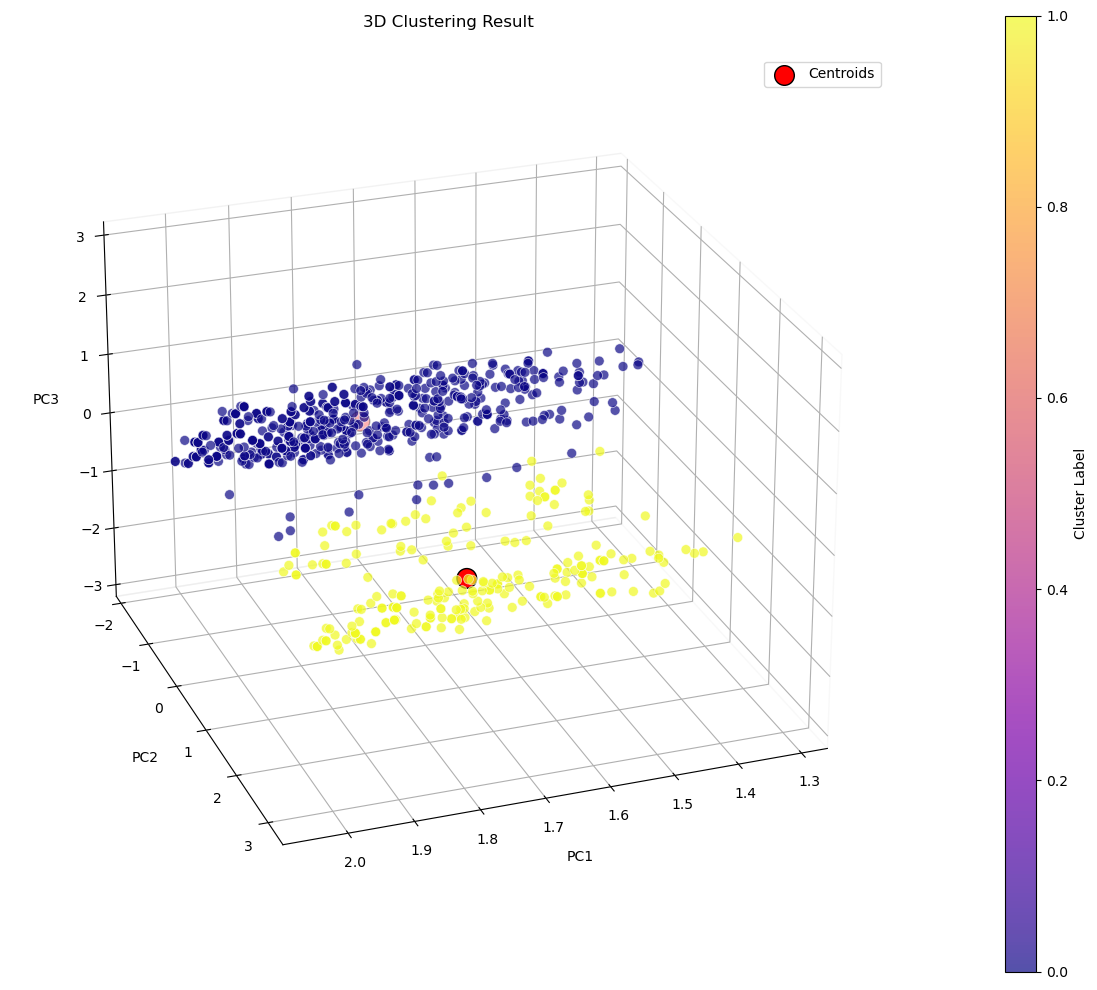

In [25]:
# Create a 3D subplot with enhanced style
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d', frame_on=True)

# Scatter plot with enhanced style
scatter = ax.scatter(X_svd[:, 0], X_svd[:, 1], X_svd[:, 2], c=cluster_labels, cmap='plasma', s=50, alpha=0.7, edgecolors='w', linewidth=0.5)
centroids = ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 2], c='red', marker='o', s=200, edgecolors='k', label='Centroids')

# Set labels, title, and grid
ax.set_xlabel('PC1', labelpad=10)
ax.set_ylabel('PC2', labelpad=10)
ax.set_zlabel('PC3', labelpad=10)
ax.set_title(f'3D Clustering Result', pad=20)
ax.grid(True, linestyle='--', alpha=0.5)
ax.w_xaxis.pane.fill = ax.w_yaxis.pane.fill = ax.w_zaxis.pane.fill = False  # Remove the default pane background

# Optionally set the view angle for better visualization
ax.view_init(elev=25, azim=70)

# Add a colorbar and legend
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, aspect=30)
cbar.set_label('Cluster Label')
ax.legend(handles=[centroids], loc='upper right')

plt.tight_layout()
plt.show()


In [26]:
loan = X.copy()
loan['cluster_label'] = cluster_labels

In [27]:
from IPython.display import display

# Assuming that you have already loaded the loan DataFrame

variable_list = list_sample

dfs = []

for variable in variable_list:
    variable_analysis = pd.crosstab(loan[variable], loan['cluster_label'])
    variable_analysis_percentage = variable_analysis.div(variable_analysis.sum(axis=0), axis=1) * 100  # Calculate percentage per cluster
    variable_analysis_percentage_rounded = variable_analysis_percentage.round(2)
    variable_analysis_combined = pd.concat([variable_analysis, variable_analysis_percentage_rounded], axis=1)
    variable_analysis_combined.columns = [f'Cluster {i} Count' for i in variable_analysis.columns] + [f'Cluster {i} %' for i in variable_analysis.columns]
    dfs.append(variable_analysis_combined)

dfs_formatted = []

for df in dfs:
    count_cols = [col for col in df.columns if 'Count' in col]
    percentage_cols = [col for col in df.columns if '%' in col]

    # Apply conditional formatting using seaborn
    cm = sns.light_palette("green", as_cmap=True)
    styler = df.style.background_gradient(cmap=cm, subset=count_cols, axis=0).background_gradient(cmap='PuBu', subset=percentage_cols, axis=0)
    
    # Format the percentage columns to have 2 decimal places and append the '%' symbol
    for col in percentage_cols:
        styler.format({col: "{:.2f}%"})

    dfs_formatted.append(styler)

# Display the formatted dataframes
for i, styler in enumerate(dfs_formatted):
    print(f"Cross-tabulation for {variable_list[i]}:")
    display(styler)
    print()


Cross-tabulation for gender:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
gender,,,,
Female,305,105,55.350000,47.73%
Male,246,115,44.650000,52.27%



Cross-tabulation for client_age:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
client_age,,,,
22.000000,1,0,0.180000,0.00%
24.000000,1,0,0.180000,0.00%
25.000000,14,7,2.540000,3.18%
26.000000,31,22,5.630000,10.00%
27.000000,51,23,9.260000,10.45%
28.000000,60,30,10.890000,13.64%
29.000000,70,23,12.700000,10.45%
30.000000,61,20,11.070000,9.09%
31.000000,66,20,11.980000,9.09%



Cross-tabulation for applicAmount:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
applicAmount,,,,
10000000,0,153,0.000000,69.55%
11000000,0,1,0.000000,0.45%
12000000,0,5,0.000000,2.27%
13000000,0,1,0.000000,0.45%
14000000,0,1,0.000000,0.45%
15000000,12,59,2.180000,26.82%
16000000,2,0,0.360000,0.00%
17000000,1,0,0.180000,0.00%
18000000,3,0,0.540000,0.00%



Cross-tabulation for personMarriageStatus:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
personMarriageStatus,,,,
Kết hôn,252,76,56.120000,46.34%
Đã ly hôn (vợ / chồng),28,9,6.240000,5.49%
Độc thân,169,79,37.640000,48.17%



Cross-tabulation for region:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
region,,,,
HIGHLANDS,24,13,4.360000,5.91%
MEKONG,60,23,10.890000,10.45%
NORTHCENTRAL,19,11,3.450000,5.00%
NORTHEAST,33,12,5.990000,5.45%
NORTHWEST,5,3,0.910000,1.36%
REDRIVER,124,47,22.500000,21.36%
SOUTHCENTRAL,47,15,8.530000,6.82%
SOUTHEAST,239,96,43.380000,43.64%



Cross-tabulation for product:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
product,,,,
DICO MED_SMART YOUTH,551,220,100.000000,100.00%



Cross-tabulation for customer_details_cluster:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
customer_details_cluster,,,,
0,134,52,24.320000,23.64%
1,94,58,17.060000,26.36%
2,154,54,27.950000,24.55%
3,169,56,30.670000,25.45%



Cross-tabulation for loan_details_cluster:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
loan_details_cluster,,,,
0,57,4,10.340000,1.82%
1,0,216,0.000000,98.18%
2,190,0,34.480000,0.00%
3,304,0,55.170000,0.00%



Cross-tabulation for areaandphone_clusters:


,Cluster 0 Count,Cluster 1 Count,Cluster 0 %,Cluster 1 %
areaandphone_clusters,,,,
0,197,74,35.750000,33.64%
1,99,49,17.970000,22.27%
2,142,59,25.770000,26.82%
3,113,38,20.510000,17.27%


In [28]:
X_1['cluster_labels'] = cluster_labels

In [29]:

# Define 'BAD'
X_1['BAD'] = (X_1['FPD30'] > 0).astype(int)

In [30]:
X_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 427 to 49756
Data columns (total 55 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gmt_received_date          771 non-null    object        
 1   gmt_received_week          771 non-null    object        
 2   gmt_received_month         771 non-null    object        
 3   product                    771 non-null    object        
 4   gender                     771 non-null    object        
 5   client_age                 771 non-null    float64       
 6   id_type                    771 non-null    object        
 7   customer_province_current  771 non-null    object        
 8   job                        771 non-null    object        
 9   marital_status             771 non-null    object        
 10  region                     771 non-null    object        
 11  telco_operator             682 non-null    object        
 12  educ

In [31]:
import shutil

# Assuming you have a DataFrame named loan_data
file_name = 'DICO MED_SMART YOUTH.xlsx'
X_1.to_excel(file_name, index=False)

# Move the Excel file to the desired directory
destination_path = 'C:\\Users\\lekho\\OneDrive\\FIZO\\Loan Behavior\\' + file_name
shutil.move(file_name, destination_path)


'C:\\Users\\lekho\\OneDrive\\FIZO\\Loan Behavior\\DICO MED_SMART YOUTH.xlsx'